# **DATA EXPLORATION**

This notebook explores the **New York City Airbnb Listings Dataset** using **NumPy for data handling and computation**, and **Matplotlib/Seaborn for visualization**  


## **1. Acquiring and Loading Data**
### **a. Import Libraries**

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('..'))

from src import data_processing as dp
from src import visualization as viz

import importlib
importlib.reload(dp)


<module 'src.data_processing' from 'd:\\School\\4\\Semester 1\\Programming for Data Science\\L02\\LTKHDL-Airbnb\\src\\data_processing.py'>

### **b. Load Dataset**

In [2]:
data_path = '../data/raw/AB_NYC_2019.csv'

raw_data, header = dp.load_data(data_path)

# Review dataset structure
print("Shape:", raw_data.shape)
print("Columns:", header)
print("Sample:\n", raw_data[:3])

Shape: (48895, 16)
Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
Sample:
 [['2539' 'Clean & quiet apt home by the park' '2787' 'John' 'Brooklyn'
  'Kensington' '40.64749' '-73.97237' 'Private room' '149' '1' '9'
  '2018-10-19' '0.21' '6' '365']
 ['2595' 'Skylit Midtown Castle' '2845' 'Jennifer' 'Manhattan' 'Midtown'
  '40.75362' '-73.98377' 'Entire home/apt' '225' '1' '45' '2019-05-21'
  '0.38' '2' '355']
 ['3647' 'THE VILLAGE OF HARLEM....NEW YORK !' '4632' 'Elisabeth'
  'Manhattan' 'Harlem' '40.80902' '-73.9419' 'Private room' '150' '3' '0'
  '' '' '1' '365']]


### **c. Initial Observations**

- The dataset has `48895` rows and `16` columns.
- Columns include listing information such as name, host, price, location, and reviews.
- The dataset contains text columns, numeric columns, and likely missing or invalid values.
- Numeric columns will need conversion from string → float using NumPy.
- Some long text values containing commas, therefore `csv.reader` was used instead of `np.genfromtxt()` to avoid structural errors.


## **2. Understanding Data**

### **a. Detect Type**

In [3]:
def detect_type(col):
    # Try numeric
    try:
        float_vals = col.astype(float)
        # numeric but could be categorical if too few unique values
        if len(np.unique(float_vals)) < 20:
            return "Categorical"
        return "Numeric"
    except:
        # Try dates
        try:
            _ = np.array([np.datetime64(x) for x in col if x.strip() != ''])
            return "Date"
        except:
            return "Text"


for idx, col_name in enumerate(header):
    col_data = raw_data[:, idx]
    print(f"{idx:02d} | {col_name:30} | {detect_type(col_data)}")

00 | id                             | Numeric
01 | name                           | Text
02 | host_id                        | Numeric
03 | host_name                      | Text
04 | neighbourhood_group            | Text
05 | neighbourhood                  | Text
06 | latitude                       | Numeric
07 | longitude                      | Numeric
08 | room_type                      | Text
09 | price                          | Numeric
10 | minimum_nights                 | Numeric
11 | number_of_reviews              | Numeric
12 | last_review                    | Date
13 | reviews_per_month              | Text
14 | calculated_host_listings_count | Numeric
15 | availability_365               | Numeric


In [4]:
price = dp.safe_convert(raw_data[:, header.index("price")])
latitude = dp.safe_convert(raw_data[:, header.index("latitude")])
longitude = dp.safe_convert(raw_data[:, header.index("longitude")])
min_nights = dp.safe_convert(raw_data[:, header.index("minimum_nights")])
reviews = dp.safe_convert(raw_data[:, header.index("number_of_reviews")])
reviews_per_month = dp.safe_convert(raw_data[:, header.index("reviews_per_month")])
reviews_per_month = np.nan_to_num(reviews_per_month)
availability = dp.safe_convert(raw_data[:, header.index("availability_365")])

### **b. Missing Values**

In [5]:
missing_count = np.sum(raw_data == '', axis=0)

for idx, col in enumerate(header):
    print(f"{col:35} -> {missing_count[idx]} missing")

id                                  -> 0 missing
name                                -> 16 missing
host_id                             -> 0 missing
host_name                           -> 21 missing
neighbourhood_group                 -> 0 missing
neighbourhood                       -> 0 missing
latitude                            -> 0 missing
longitude                           -> 0 missing
room_type                           -> 0 missing
price                               -> 0 missing
minimum_nights                      -> 0 missing
number_of_reviews                   -> 0 missing
last_review                         -> 10052 missing
reviews_per_month                   -> 10052 missing
calculated_host_listings_count      -> 0 missing
availability_365                    -> 0 missing


- The reason why these are listings that have **0 reviews**
    - If a listing has never been reviewed, it cannot have a date for the "last review."
    - It also cannot have a "reviews per month" calculation (mathematically, it's either undefined or zero).
- For reviews_per_month: fill the missing values with 0. These are valid listings that just haven't been booked/reviewed yet.


In [6]:
# Replace reviews_per_month missing with 0
rpm_idx = 13

# Step 1: replace empty string '' with '0'
raw_data[:, rpm_idx][raw_data[:, rpm_idx] == ''] = '0'

# Step 2: convert column to float
reviews_per_month = raw_data[:, rpm_idx].astype(float)


In [7]:
missing_count = np.sum(raw_data == '', axis=0)

for idx, col in enumerate(header):
    print(f"{col:35} -> {missing_count[idx]} missing")

id                                  -> 0 missing
name                                -> 16 missing
host_id                             -> 0 missing
host_name                           -> 21 missing
neighbourhood_group                 -> 0 missing
neighbourhood                       -> 0 missing
latitude                            -> 0 missing
longitude                           -> 0 missing
room_type                           -> 0 missing
price                               -> 0 missing
minimum_nights                      -> 0 missing
number_of_reviews                   -> 0 missing
last_review                         -> 10052 missing
reviews_per_month                   -> 0 missing
calculated_host_listings_count      -> 0 missing
availability_365                    -> 0 missing


### **c. Descriptive Statistics**

In [8]:
def stats(arr):
    return {
        'median': np.nanmedian(arr),
        'mean': np.nanmean(arr),
        'min': np.nanmin(arr),
        'max': np.nanmax(arr),
        'std': np.nanstd(arr)
    }

stats(price)

{'median': 106.0,
 'mean': 152.7206871868289,
 'min': 0.0,
 'max': 10000.0,
 'std': 240.15171391941718}

### **Price Distribution**

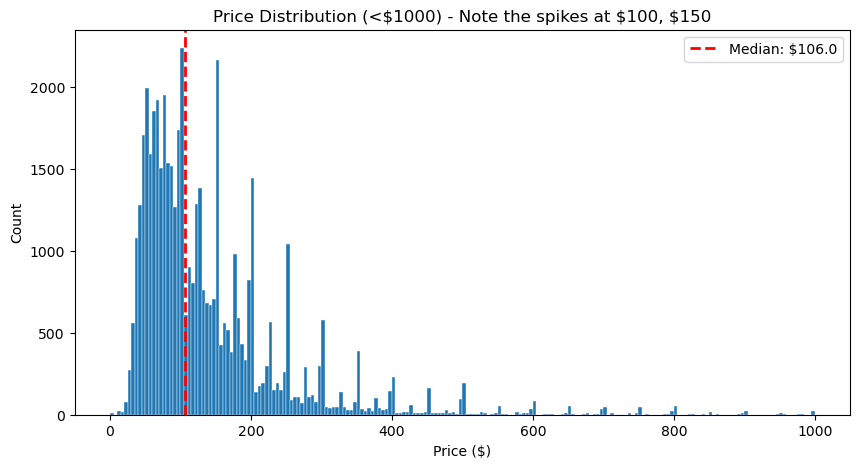

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(price[price < 1000], bins=200, edgecolor='white', linewidth=0.3)

# Add a vertical line for the median
median_price = np.nanmedian(price)
plt.axvline(median_price, color='red', linestyle='dashed', linewidth=2, label=f'Median: ${median_price}')

plt.title("Price Distribution (<$1000) - Note the spikes at $100, $150")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.legend()
plt.show()

- The histogram isn't smooth; it has sharp spikes at exactly $50, $100, $150, and $200.  Airbnb hosts are humans, not algorithms. They tend to price their assets in "round numbers" rather than calculating an exact value (e.g., $97 or $103). ⟶ A host pricing their unit at $99 or $149 could likely gain a competitive advantage by undercutting the massive competition clustered at the round numbers.

- When you group by neighborhood (as you did in Cell 12/13), Manhattan has a median price of $150, while Brooklyn is $90, and Queens is $75. Crossing the bridge from Manhattan to Brooklyn or Queens offers travelers a ~40-50% discount. ⟶ For a "Budget Travel" recommender system, you should almost exclusively recommend Brooklyn/Queens/Bronx listings, as Manhattan is statistically an outlier in price.

- We found that ~20% (10,052) of the listings have 0 reviews (missing reviews_per_month). A huge portion of the inventory is stagnant or new. These listings likely struggle to get their first booking because users trust reviews.  ⟶ If you were Airbnb, you might design a "New Listing Promotion" algorithm to boost these 0-review properties so they can get their first customer and start the flywheel.

### **Minimum Nights Distribution**

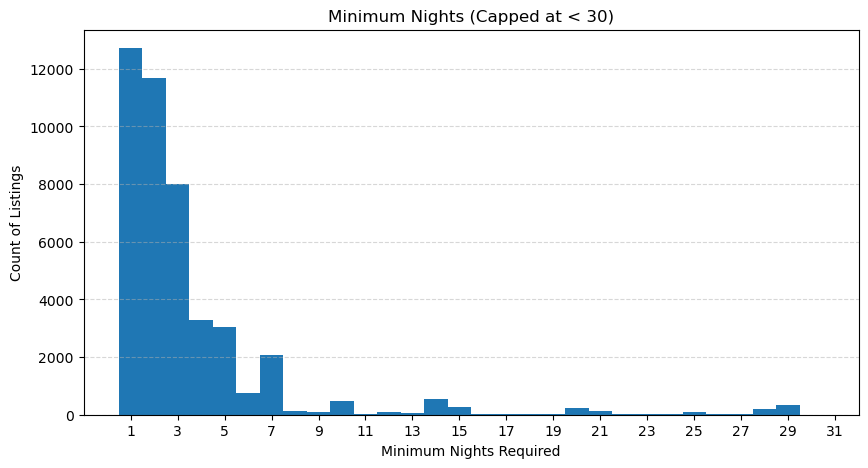

In [10]:
plt.figure(figsize=(10,5))
plt.hist(min_nights[min_nights < 30], bins=np.arange(1, 32), linewidth=0.5, align='left')
plt.title("Minimum Nights (Capped at < 30)")
plt.xlabel("Minimum Nights Required")
plt.ylabel("Count of Listings")
plt.xticks(np.arange(1, 32, 2))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


- While 1-night minimums are the most common, the bar for 2 nights is nearly as tall. This indicates a massive split in host strategy. 
    - 1-Night Hosts: Prioritize maximum occupancy and are willing to handle daily cleaning/key exchanges. 
    - 2-Night Hosts: Are avoiding "Turnover Fatigue." The cost and effort of cleaning an apartment for a single night's revenue often isn't worth it. They force a 2-night stay to ensure the cleaning fee and effort are amortized over a larger payout.
- A noticeable bump at 3 nights compared to 4 or 5. This is the "Friday to Sunday" crowd. Hosts set this restriction to prevent someone from booking just Saturday night, which would leave Friday and Sunday unbookable (orphaned dates).
- There is a distinct, isolated spike at 7 days. This corresponds to hosts targeting the "one-week vacation" segment. These hosts often pair this minimum with a "weekly discount" (e.g., 10% off) to encourage longer, lower-maintenance stays.

### **Room Type Distribution**

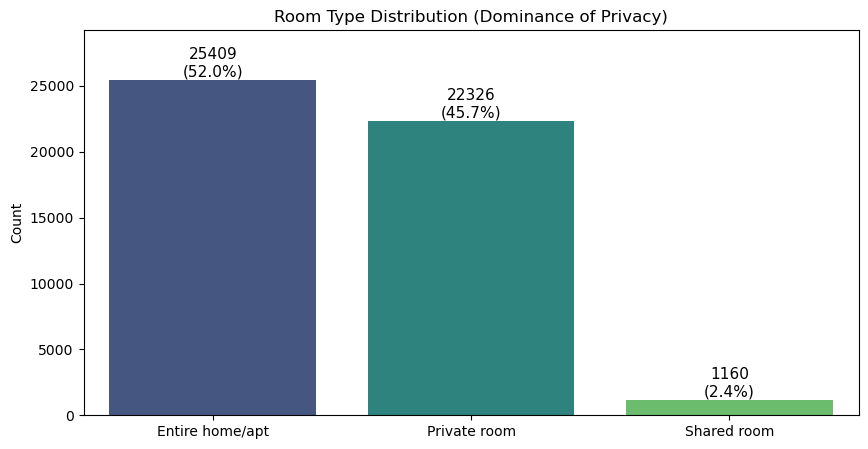

In [11]:
room_types, room_counts = np.unique(raw_data[:, header.index("room_type")], return_counts=True)
total_listings = np.sum(room_counts)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=room_types, y=room_counts, palette="viridis", hue=room_types, legend=False)

for i, count in enumerate(room_counts):
    percentage = (count / total_listings) * 100
    # Place text slightly above the bar
    ax.text(i, count + 300, f"{count}\n({percentage:.1f}%)", 
            ha='center', fontsize=11, color='black')

plt.title("Room Type Distribution (Dominance of Privacy)")
plt.ylabel("Count")
plt.ylim(0, max(room_counts) * 1.15) # Add headroom for the text
plt.show()


- While the overall NYC market is roughly a 50/50 split between Entire Homes and Private Rooms, this varies drastically by location. 
    - Manhattan is the only borough dominated by Entire Homes (61%). 
    - Queens and The Bronx are dominated by Private Rooms (~60%). 
    - Brooklyn is the true "mixed" market (roughly 50/50).  
**⟶** This tells us about the type of host in each area. Manhattan hosts are more likely to be commercial investors (renting out full apartments), whereas Queens hosts are more likely to be residents (renting out a spare room in their actual home).

- The median price for an Entire home/apt is $160, compared to $70 for a Private room. Privacy costs a premium of ~128%. **⟶** For a budget traveler (e.g., willing to spend $100/night), recommending an "Entire Home" in Manhattan is mathematically impossible. The algorithm must pivot them to "Private Rooms" in Manhattan or "Entire Homes" in the outer boroughs (Brooklyn/Queens) to fit their budget.

- Shared rooms are statistically negligible (2.4%) and have a median price of $45. This price is dangerously close to the Private room price ($70). **⟶** The value proposition of "Shared rooms" is weak. Unless a user is on an extreme shoestring budget, the small upgrade cost to get a private room is almost always worth it.

### **Neighbourhood Group Distribution**

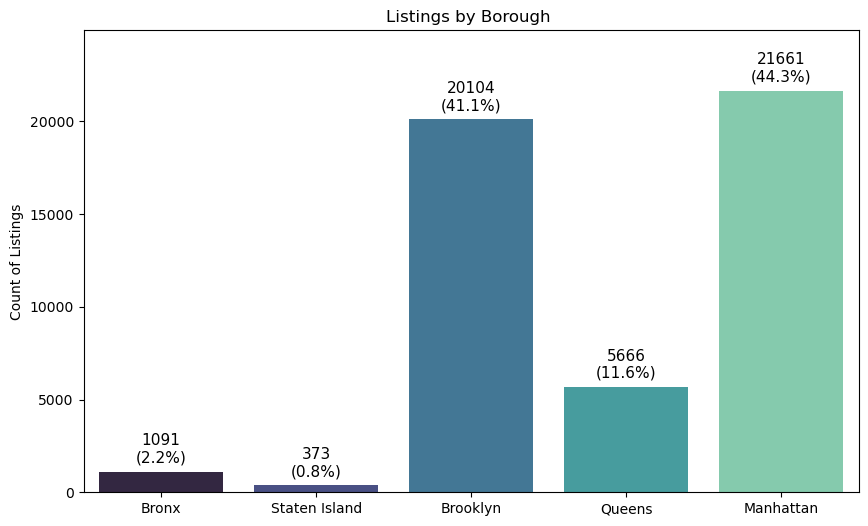

In [12]:
neighbourhood_groups, ngroup_counts = np.unique(raw_data[:, header.index("neighbourhood_group")], return_counts=True)

sorted_neighbourhood_indices = np.argsort(ngroup_counts[::-1])
sorted_neighbourhoods = neighbourhood_groups[sorted_neighbourhood_indices]
sorted_ncounts = ngroup_counts[sorted_neighbourhood_indices]

plt.figure(figsize=(10,6))
ax = sns.barplot(x=sorted_neighbourhoods, y=sorted_ncounts, palette="mako", hue=sorted_neighbourhoods, legend=False)

total = np.sum(sorted_ncounts)
for i, count in enumerate(sorted_ncounts):
    pct = (count / total) * 100
    ax.text(i, count + 500, f"{count}\n({pct:.1f}%)", 
            ha='center', fontsize=11, color='black')

plt.title("Listings by Borough ")
plt.ylabel("Count of Listings")
plt.ylim(0, max(sorted_ncounts) * 1.15) # Add headroom
plt.show()

- Manhattan (44.3%) and Brooklyn (41.1%) together account for 85.4% of all listings in New York City. The NYC short-term rental market is geographically highly concentrated. It is effectively a "two-borough market."
- Queens is a distant third with ~11.6% of listings. While much smaller than the "Big Two," it is 4x larger than the Bronx and Staten Island combined. Queens likely captures the "Budget" and "Airport Transit" market.
- The Bronx (2.2%) and Staten Island (0.8%) are statistically negligible. These areas have not been penetrated by the tourism economy. Listings here are likely purely residential or serving specific local needs (visiting family) rather than general tourism.

### **Geospatial Plot**

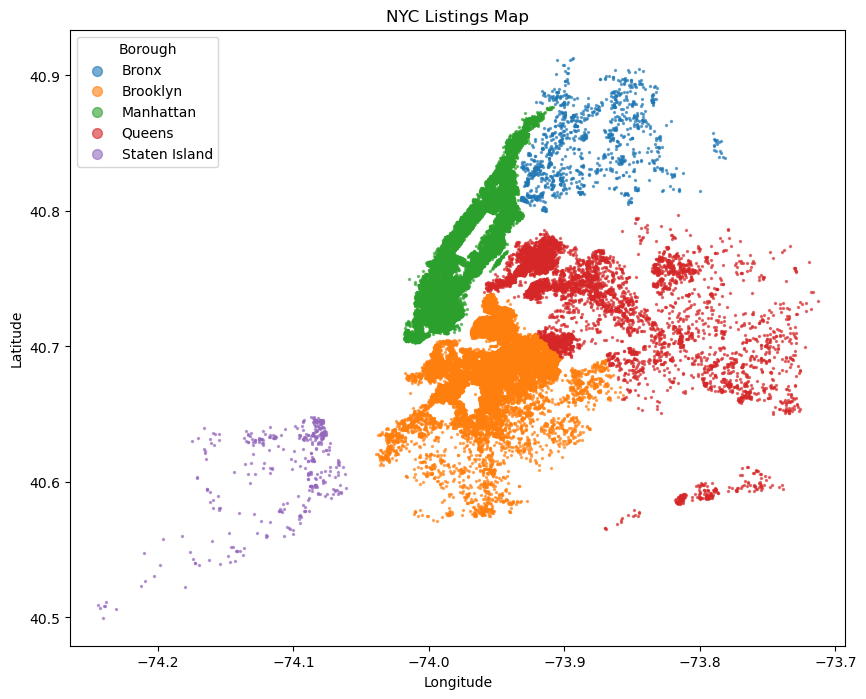

In [13]:
# Setup
groups = raw_data[:, header.index("neighbourhood_group")]
unique_groups = np.unique(groups)
cmap = plt.get_cmap('tab10')
plt.figure(figsize=(10, 8))

# Loop through each borough and plot it separately
for i, group in enumerate(unique_groups):
    # Create a "mask" to select only rows for this specific borough
    mask = (groups == group)
    
    plt.scatter(longitude[mask], latitude[mask], 
                s=2, alpha=0.6, 
                color=cmap(i),  # Pick the ith color specifically
                label=group)

# Final Styling
plt.axis('equal')
plt.title("NYC Listings Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(markerscale=5, loc='upper left', title="Borough")
plt.show()

- Notice the density of points in Manhattan. It is almost a solid block of color. In Lower Manhattan and Midtown, the density of listings is so high that it likely impacts housing availability for locals. This visualizes why NYC has such strict regulations. 
- Look at Brooklyn (the orange cluster below Manhattan). It is not evenly distributed. The listings are packed tightly along the river and fade away quickly as you move East/South. Airbnb activity is a proxy for gentrification. It hugs the subway lines that connect to Manhattan.
- Staten Island (bottom left) is mostly empty space. Despite being physically large, it has almost no participation in the short-term rental economy.

## **3. Business Questions**

### **Q1: Which borough is the most expensive?**

Median Price by Borough (Listings < $500):
Manhattan       -> $143
Brooklyn        -> $90
Queens          -> $75
Staten Island   -> $75
Bronx           -> $65


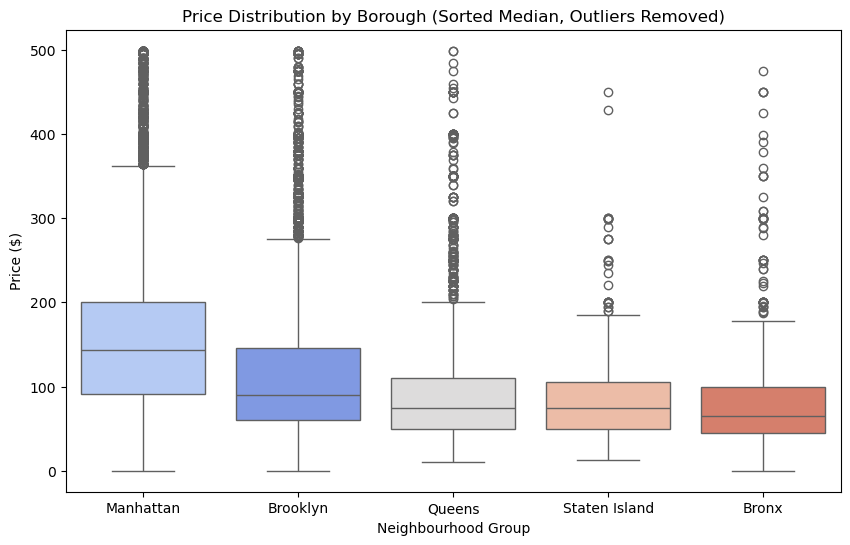

In [14]:
filter_mask = price < 500

# Apply the filter to create "Clean" arrays
clean_prices = price[filter_mask]
clean_boroughs = raw_data[filter_mask, header.index("neighbourhood_group")]

unique_boroughs = np.unique(clean_boroughs)
median_data = []

for b in unique_boroughs:
    # Check rows for this specific borough within clean arrays
    b_mask = clean_boroughs == b 
    med = np.nanmedian(clean_prices[b_mask])
    median_data.append((b, med))

median_data.sort(key=lambda x: x[1], reverse=True)
print("Median Price by Borough (Listings < $500):")
for b, med in median_data:
    print(f"{b:15} -> ${med:.0f}")

sorted_names = [x[0] for x in median_data]

plt.figure(figsize=(10,6))
sns.boxplot(x=clean_boroughs, 
            y=clean_prices, 
            order=sorted_names,    
            palette='coolwarm',
            hue=clean_boroughs,    
            legend=False)           

plt.title("Price Distribution by Borough (Sorted Median, Outliers Removed)")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Price ($)")
plt.show()

- The median price drops from $143 in Manhattan to $90 in Brooklyn. A traveler saves roughly 60% simply by crossing the bridge. This suggests that location (Manhattan) is the single biggest driver of price in the dataset, overpowering other factors like room size or amenities. 
- Queens and Staten Island have the exact same median price ($75). This is counter-intuitive because Queens is generally considered more "popular" for tourists (due to subway access and airports). This suggests a quality/size trade-off. In Queens, $75 likely gets you a smaller space (due to higher demand), whereas in Staten Island, that same $75 might get you a larger space (to compensate for the commute/isolation). 
- The Bronx is the cheapest option at $65, but it is not drastically cheaper than Queens ($75). There seems to be a "hard floor" for Airbnb pricing in NYC around $60-65. Below this price, it may not be profitable for hosts to operate given the costs of cleaning, electricity, and platform fees.

### **Q2: Does room type affect price?**

Median Price by Room Type:
Entire home/apt      -> $160
Private room         -> $70
Shared room          -> $45


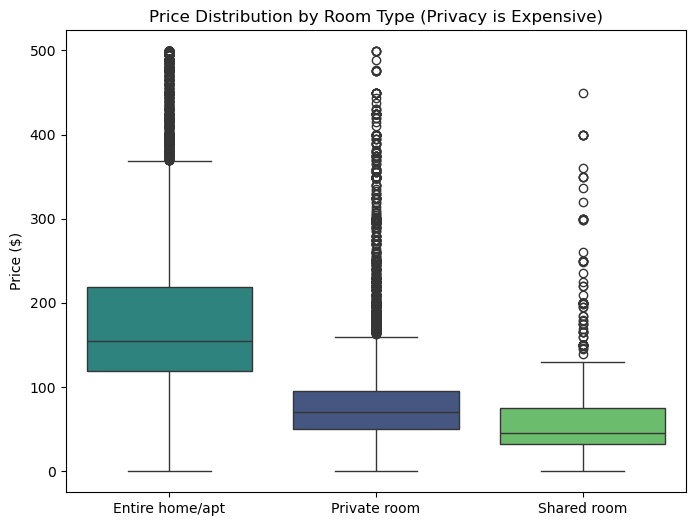

In [15]:
print("Median Price by Room Type:")
room_types = np.unique(raw_data[:, header.index("room_type")])
room_prices = []

for t in room_types:
    # Get prices for this room type
    mask = raw_data[:, header.index("room_type")] == t
    p = price[mask]
    med = np.nanmedian(p)
    room_prices.append((t, med))

# Sort High -> Low
room_prices.sort(key=lambda x: x[1], reverse=True)

for t, med in room_prices:
    print(f"{t:20} -> ${med:.0f}")

# Boxplot
mask = price < 500
clean_prices = price[mask]
clean_types = raw_data[mask, header.index("room_type")]

# Get sorted order for the plot
sorted_types = [x[0] for x in room_prices]

plt.figure(figsize=(8,6))
sns.boxplot(x=clean_types, y=clean_prices, order=sorted_types, palette='viridis', hue=clean_types, legend=False)
plt.title("Price Distribution by Room Type (Privacy is Expensive)")
plt.ylabel("Price ($)")
plt.show()

- An "Entire home/apt" ($160) costs more than double a "Private room" ($70). Privacy is the most expensive commodity in NYC. The jump from sharing an apartment to having it to yourself is the steepest price hike in the entire dataset.
- "Private rooms" ($70) are only slightly more expensive than "Shared rooms" ($45). For just $25 more, a guest upgrades from a bunk bed/couch to a private door. This suggests "Shared rooms" are a bad value proposition. Unless a user is absolutely broke, the $25 upgrade is almost always worth it. A recommender system should heavily bias users toward Private Rooms over Shared Rooms.